<font size="12">Lidar Model</font>

<font size="6"> Import libraries</font>

In [19]:
import os
import torch
import pandas as pd
import mlflow

from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
import pickle as pkl
import matplotlib.pyplot as plt


<font size="6">Read Data & Convert to Tensors</font>

<font size="2">Along with reading the data ,we have to do EDA and Transformation of data before we move futher into developing models.</font>

In [20]:

# Read data, convert to tensors

data_samples ="sonar.csv" 
data = pd.read_csv(data_samples, header=None)
# data.head()
# data.info()
# data.shape
# data.ndim
# data.describe()
# data.isnull().sum()
# data.nunique()
# data.memory_usage( )

In [21]:
X = data.iloc[:, 0:3].values
y = data.iloc[:, 3].values

# convert into PyTorch tensors
trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)



print(trainingSetX.shape)
print(trainingSetY.shape)



loader = DataLoader(list(zip(trainingSetX,trainingSetY)), shuffle=True)


torch.Size([3200, 3])
torch.Size([3200, 1])


<font size="2">If cuda is used, it will run your model faster than using your device memory</font>

In [22]:

# use Cuda Y/N 


device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)


print(f"Using {device} device")



Using cpu device


<font size="6">Neural Network construction</font>

<font size="2">We can use any number of hidden layers but its better to choose the layers by first experimenting with different number of layers. Also in our model we have used SiLU as our softening function before the output layer because we have negative value as well in our output and SiLU is good in squeezing the negative values. </font>

In [23]:

#Neural Network construction


class NeuralNetwork(nn.Module):
    
    def __init__(self, inputs, outputs):
        
        super().__init__()
        
        # Simple linear connections
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 36),
            nn.ReLU(),
            nn.Linear(36, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.SiLU(),
            nn.Linear(12, outputs),
            # nn.ReLU()
        )
            
    def forward(self, x):
        
        return self.linear_relu_stack(x)



<font size="6">Model Training</font>

<font size="2">In our sonar model we have 2 input feartures(sensors) and  single output. We have to keep experimenting with different learning rates and epochs until we get the lowest loss value. The lower the loss function the better the model is. Here we have used mini batch to feed for every epoch.</font> 

In [24]:


# Model Training: 
model = NeuralNetwork(3, 1)
print(model)


# Take binary cross entropy as loss function (one output interpreted as binary)
# lossFunction = nn.BCELoss()
lossFunction = nn.MSELoss()

learningRate = 0.00008

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.Adam(model.parameters(), lr=learningRate)

epochs = 200



losses = []





for epoch in range(epochs):
    
    
    added = False
    epochLoss = 0.0
    
    for x, y in loader:
    
        # Reset the gradient delta's (dw, db)
        gradientDescent.zero_grad()

        # Forward step
        yhat = model(x)

        # Compute loss
        loss = lossFunction(yhat, y)
        
        if not added:
            
            added = True
        
            # Keep track of loss
            epochLoss += loss.item()

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent.step()
        
    losses.append(epochLoss / len(loader))
        
        



NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=12, bias=True)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)


<font size="6">Machine Learning flow(ML flow)</font>

<font size="2">Ml Flow helps in racking component allows you to record machine model training sessions (called runs) & run queries</font>

In [25]:
#Machine Learning Flow

sensor = "sonar"
hidden_layers = "36_24_12"
activation = "ReLU_ReLU_SiLU"

mlflow.set_experiment('NeuralNetwork')

# with mlflow.start_run(run_name=f'Neural net ({sensor}) | layers: {len(hidden_layers)}, epochs: {epochs}, lr: {lr}, batchsize: {batch_size}'):
with mlflow.start_run(run_name=f'NN({sensor}) {hidden_layers}, epochs: {epochs}, lr: {learningRate}'):


    mlflow.log_param('sensor', sensor)
    mlflow.log_param('data_samples', data_samples)
    
    mlflow.log_param('hidden_layers', hidden_layers)
    mlflow.log_param('activation', activation)

    mlflow.log_param('epochs', epochs)
    mlflow.log_param('lr', learningRate)
   # mlflow.log_param('batch_size', batch_size)

    mlflow.log_param('optimizer', gradientDescent)
    mlflow.log_param('loss_fn', lossFunction)
    mlflow.log_metric('epochLoss', losses[-1])


<font size="6">Saving the Model</font>

<font size="2">We are saving the model using pytorch but actually pytorch itself uses the module pickle to save the model.</font>

In [26]:
# # Saving Model
# filehandler = open('SDCar.pkl', 'wb')
# pkl.dump(model.linear_relu_stack, filehandler)

filehandler = open('SDCar_sonar.pth', 'wb')
torch.save(model.linear_relu_stack, filehandler)

<font size="6">Plotting the Loss function against the epochs</font>

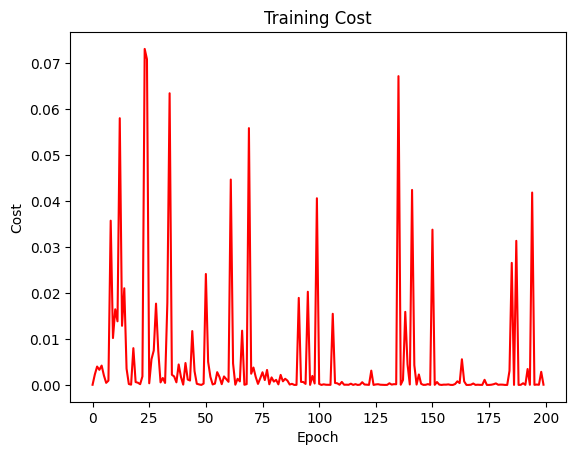

In [27]:
# Compare

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(epochs)], losses, 'red')
plt.show()

